In [ ]:
# default_exp analyze

# analyze

> Tools for computing movement/pose similarity time series, clustering for single- and multi-dancer videos

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import openpifpaf
from openpifpaf.plugins.coco.constants import COCO_KEYPOINTS, COCO_PERSON_SKELETON

import numpy as np
import matplotlib.pyplot as plt
from skbio.stats.distance import mantel
from scipy.spatial.distance import squareform
from scipy.interpolate import interp1d
from sklearn.cluster import OPTICS
from Bio import pairwise2
from choreo_k.matrixify import get_pose_matrix, get_normalized_coords, compare_poses_cosine, get_laplacian_matrix

import warnings
warnings.filterwarnings(
  action='ignore', module='matplotlib.figure', category=UserWarning,
  message=('This figure includes Axes that are not compatible with tight_layout, '
           'so results might be incorrect.'))

def smooth_series(x, window_len=11, window='flat'):
    """ Smooth a time series via a sliding window average
        From https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """
    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")

    if window_len<3:
        print("WARNING: window length too small for smoothing, returning input data")
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')

    # Move the window 1/2 width back to avoid lag
    if window_len % 2 == 0:
        return y[int(window_len/2)-1:-(int(window_len/2))]
    else:
        return y[int(window_len/2):-(int(window_len/2))]


def corr_time_series_matrix(pose_data, method='distance'):
    """ Generate a full time-series pose similarity heatmap for all available
        poses and frames from the video. This code can use either pose
        characterization approach; in practice, the distance matrix-based analyses
        take longer to calculate but are more accurate.
    """
    pose_correlations = []
    for i, pi in enumerate(pose_data):
        print("Comparing frame",i,"to the rest")
        corr_row = []
        if method == 'distance':
            mi = get_pose_matrix(pi)
        else: # method == 'laplacian'
            mi = get_laplacian_matrix(pi, figure_type='flipped_figures')
        for j, pj in enumerate(pose_data):
            if j < i:
                corr_row.append(pose_correlations[j][i])
            elif j == i:
                corr_row.append(float(1))
            else:
                if mi is None:
                    corr_row.append(float(0))
                elif method == 'distance':
                    mj = get_pose_matrix(pj)
                    if mj is None:
                        corr_row.append(float(0))
                    else:
                        corr_row.append(mantel(mi, mj)[0])
                else: # method == 'laplacian'
                    mj = get_laplacian_matrix(pj, figure_index=0, figure_type='flipped_figures')
                    if mj is None:
                        corr_row.append(float(0))
                    else:
                        corr_row.append(1 - abs(np.subtract(mi.todense(), mj.todense()).sum()))
        pose_correlations.append(corr_row)

    return pose_correlations


def correlate_time_series(pose_data1, pose_data2, method='correlate', figure_type='figures'):
    if pose_data2 is None:
        pose_data2 = pose_data1
    pose_correlations = []
    for i, pi in enumerate(pose_data1):
        print("Comparing frame",i,"to the rest")
        corr_row = []
        if method == 'correlate': # Distance matrix correlation
            mi = get_pose_matrix(pi, figure_type=figure_type)
        elif method == 'distance': # Cosine similarity of normalized keypoints
            mi = get_normalized_coords(pi, figure_type=figure_type)
        else:
            mi = get_laplacian_matrix(pi, figure_type=figure_type)
        for j, pj in enumerate(pose_data2):
            if mi is None:
                corr_row.append(float(0))
            elif method == 'correlate':
                mj = get_pose_matrix(pj, figure_type=figure_type)
                if mj is None:
                    corr_row.append(float(0))
                else:
                    corr_row.append(mantel(mi, mj)[0])
            elif method == 'distance':
                mj = get_normalized_coords(pj, figure_type=figure_type)
                if mj is None:
                    corr_row.append(float(0))
                else:
                    corr_row.append(compare_poses_cosine(mi, mj))
            else:
                mj = get_laplacian_matrix(pj, figure_index=0, figure_type=figure_type)
                if mj is None:
                    corr_row.append(float(0))
                else:
                    corr_row.append(1 - abs(np.subtract(mi.todense(), mj.todense()).sum()))
        pose_correlations.append(corr_row)
        
    return pose_correlations


def fill_nans_scipy1(padata, pkind='linear'):
    """ Fill in missing values from a time series, after the first non-NAN value
        and up to the last non-NAN value. Note that scipy.interpolated.interp1d
        provides a lot more options (splines, quadratic, etc.)
    """
    
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))

    first_non_nan_index = agood_indexes[0] 
    last_non_nan_index = agood_indexes[-1]

    f = interp1d(agood_indexes
           , padata[agood_indexes]
           , bounds_error=False
           , copy=False
           , fill_value="extrapolate"
           , kind=pkind)

    interpolated = f(aindexes)
    interpolated[0:first_non_nan_index] = np.nan
    interpolated[last_non_nan_index+1:] = np.nan
    return interpolated


def movements_time_series(pose_data, pose_index=-1, method='distance', figure_type='flipped_figures', video_file=None):
    """ Calculate a time series of the differences between each pair of poses in a
        sequence. This works with a single figure (pose_index=0) or all the figures
        in the video (pose_index=-1). It can be run on its own, but typically this is
        a helper function for process_movement_series() (below).
    """
    
    per_frame_movements = []
    frame_timecodes = []

    pose_indices = []

    max_figures, total_time, total_figures = count_figures_and_time(pose_data, figure_type)

    threshold = .7

    #print("FIGURES PER FRAME IN TIME SERIES:",max_figures)

    # Typically the pose index is only specified if you know there's only one dancer
    # (in which case it's always 0)
    if pose_index != -1:
        max_figures = 1

    for f, frame in enumerate(pose_data):
        frame_movements = []
        frame_timecodes.append(frame['time'])
        if f < len(pose_data)-1:
            for p in range(max_figures):
                this_motion = np.nan
                movers = np.array([])
                # figure p must be available for both f and f-1
                # NOTE check p < len(pose_data[f][figure_type]) in case the data for that frame has been
                # truncated to [] (for example if extraneous data from the end of the video has been removed)
                if p < len(pose_data[f-1][figure_type]) and p < len(pose_data[f][figure_type]) and pose_data[f-1][figure_type][p].data.shape[0] != 0 and pose_data[f][figure_type][p].data.shape[0] != 0:
                    p1_conf = sum([c[2] for c in pose_data[f-1][figure_type][p].data]) / float(len(pose_data[f-1][figure_type][p].data))
                    p2_conf = sum([c[2] for c in pose_data[f][figure_type][p].data]) / float(len(pose_data[f][figure_type][p].data))
                    # XXX USE A BETTER CRITERION FOR SKIPPING POSES IF CONFIDENCE IS LOW
                    if p1_conf > threshold and p2_conf > threshold:
                        if method == 'distance':
                            plot_type = 'distance'
                            dmatrix1 = squareform(get_pose_matrix(pose_data[f-1], p, figure_type))
                            dmatrix2 = squareform(get_pose_matrix(pose_data[f], p, figure_type))
                            diffmatrix = np.absolute(dmatrix1 - dmatrix2)
                            movers = diffmatrix.sum(axis=1)
                            this_motion = movers.sum(axis=0) # For debugging
                        else:
                            plot_type = 'delaunay'
                            # Per-keypoint movements are not useful for Laplacian comparisons
                            similarity = compare_laplacians(pose_data[f-1], pose_data[f], p, figure_type)
                            # Can we get meaningful movement values if laplacians are of different sizes?
                            if similarity is not None:
                                movers = np.array([1 - similarity])
                
                frame_movements.append(movers)    
        
        per_frame_movements.append(frame_movements)

    return [per_frame_movements, frame_timecodes, max_figures]


def process_movement_series(pose_data, pose_index=-1, figure_type='flipped_figures', video_file=None, method='distance', interpolate=True, viz=True):
    """ Smooth, summarize, visualize movement data for one or more figures across a
        time series.
        Also visualize aggregate movement data for each keypoint, if distance matrix
        method is used.
    """
    
    print("GETTING MOVEMENT TIME SERIES")
    per_frame_results, frame_timecodes, max_figures = movements_time_series(pose_data, pose_index, method, figure_type, video_file)

    print("CALCULATING CHARACTERISTICS OF TIME SERIES")

    window_length = 5
    if video_file is not None:
        fps, total_frames = get_video_stats(video_file)
        window_length = max(window_length, int(round(fps/2.0)))

    movers = [] # To get the aggregate avg movement of each keypoint (not for Laplacian)
    movement_series = []
    frame_times = []

    smoothed_movement_series = []

    for j in range(max_figures):
        movement_series.append([])  
        smoothed_movement_series.append([])

    per_frame_movements = []
    
    for f, frame in enumerate(per_frame_results):
        frame_movements = np.zeros(TOTAL_COORDS)
        frame_times.append(frame_timecodes[f])
        for j in range(max_figures):
            if j >= len(frame) or frame[j].shape[0] == 0:
                #print("POSE",j,"HAS NO MOVEMENT DATA")
                movement_series[j].append(np.nan)
            elif method == 'distance':
                frame_movements = np.add(frame_movements, frame[j])
                movement_series[j].append(sum(frame[j]))
                movers.append(np.array(frame[j]))
            else: # method == 'laplacian'
                movement_series[j].append(frame[j][0])
            movers.append(frame[j])
        per_frame_movements.append(frame_movements)

    figure_time_series = np.array(movers)

    # Not sure if there's a meaningful way to aggregate the per-keypoint data
    # for the graph Laplacian approach (e.g., to be able to quantify how much
    # each keypoint moved during the video).
    if method == 'distance':
        movement_means = np.nanmean(figure_time_series, axis=0)
        movement_stdevs = np.nanstd(figure_time_series, axis=0)

    # Window length is half of fps (or ~5, whichever is larger)
    for j in range(max_figures):
        if interpolate:
            if np.isnan(np.nanmax(movement_series[j])):
                #print("Movement series is all nans, skipping")
                continue
            smoothed_movement_series[j] = smooth_series(fill_nans_scipy1(np.asarray(movement_series[j]), pkind='linear'),window_length).tolist()
        else:
            smoothed_movement_series[j] = smooth_series(np.array(movement_series[j]),window_length).tolist()

    if viz:
        print("VISUALIZING TIME SERIES CHARACTERISTICS")
    
        if method == 'distance':
            plt.figure()
            plt.xticks(np.arange(TOTAL_COORDS))

            plt.bar(np.arange(TOTAL_COORDS), movement_means)# yerr=movement_stdevs)

        fig = plt.figure(figsize=(12,6), constrained_layout=True)
        fig.dpi=100

        for j in range(len(smoothed_movement_series)):
            if (len(smoothed_movement_series[j]) > 0) and not np.isnan(np.nanmax(smoothed_movement_series[j])):
                plt.plot(frame_times,smoothed_movement_series[j]) #,color)
        plt.show()

    if method == 'distance':
        return [smoothed_movement_series, frame_times, per_frame_movements, movement_means, movement_stdevs]
    else:
        return [smoothed_movement_series, frame_times]
    

def average_poses(pose_series, descriptors, source_figures='zeroified_figures', flip=True):
    # Descriptors are [[frame_index, pose_index] ...]
    # XXX Add an option to average all frames/poses across a range, or an entire video?
    all_poses = []
    for descriptor in descriptors:
        all_poses.append(pose_series[descriptor[0]][source_figures][descriptor[1]].data)
    print(len(all_poses))
    poses_array = np.array(all_poses)
    avg_array = np.sum(poses_array, axis=0)/len(poses_array)
    this_annotation = openpifpaf.Annotation(keypoints=COCO_KEYPOINTS, skeleton=COCO_PERSON_SKELETON).set(avg_array, fixed_score=None)
    #this_annotation = openpifpaf.decoder.annotation.Annotation(keypoints=COCO_KEYPOINTS, skeleton=COCO_PERSON_SKELETON)
    for f, xyv in enumerate(avg_array):
        this_annotation.add(f, xyv)
    if flip:
        this_annotation = flip_detections([this_annotation])[0]
    return this_annotation

def get_feature_vectors(pose_series, figure_type='aligned_figures', method='distance'):
    # Convert matrices into feature vectors to send to the clustering algorithm
    features = []
    descriptors = []
    for f, frame_info in enumerate(pose_series):
        for p, pose_info in enumerate(frame_info[figure_type]):
            if method == 'distance':
                pose_matrix = get_pose_matrix(frame_info, p)
            else: # method == 'laplacian'
                pose_matrix = get_laplacian_matrix(frame_info, p)
            if pose_matrix is not None:
                features.append(pose_matrix)
                descriptors.append([f,p])
    return([features, descriptors])


def cluster_poses(poses_series, figure_type='aligned_figures', min_samples=50):
    # min_samples can be set according to some rule, e.g., a fraction or multiple of
    # frames per second * median number of people in a frame
    print("Getting feature vectors")
    [poses_features, descriptors] = get_feature_vectors(poses_series, figure_type)
    data_array = np.array(poses_features)
    print(data_array.shape)
    print(len(descriptors))

    print("Fitting OPTICS")
    #labels = DBSCAN(eps=100000).fit_predict(features_array)
    labels = OPTICS(min_samples=min_samples, metric='sqeuclidean').fit_predict(data_array)

    return [labels, descriptors]


def get_cluster_averages_and_indices(labels, descriptors, pose_series, figure_type='figures', video_file=None, flip_figures=False):
    """ Average the members of each pose cluster to get the representative "average"
        pose for the cluster.
    """

    label_keys = []
    for label in labels:
        if label != -1 and label not in label_keys:
            label_keys.append(label)
    label_keys.sort()

    cluster_indices = {}
    cluster_averages = {}
    cluster_avg_poses = {}

    total_poses = len(label_keys)

    for label in label_keys:
        indices = [j for j, x in enumerate(labels) if x == label]
        descs = [descriptors[indices[k]] for k in range(len(indices))]
        print("CLUSTER",label,"|",len(indices),"POSES")
        cluster_indices[label] = indices
        print(descriptors[indices[0]],"CLUSTER",label,'FIRST POSE')
        if video_file is not None:
            fig = excerpt_pose(video_file, pose_series[descriptors[indices[0]][0]], descriptors[indices[0]][1], show=True, source_figure=figure_type, flip_figures=flip_figures)
        avg_pose = average_poses(pose_series, descs)
        cluster_averages[label] = matrixify_pose(avg_pose.data)
        cluster_avg_poses[label] = avg_pose
        print("CLUSTER",label,'AVERAGE POSE')
        plot_poses(avg_pose)

    return [cluster_averages, cluster_indices, cluster_avg_poses]


def find_nearest_pose(pose_matrix, cluster_averages):
    best_corr = 0
    best_label = -1
    for label in cluster_averages:
        corr = mantel(pose_matrix, cluster_averages[label])[0]
        if corr > best_corr:
            best_label = label
            best_corr = corr
    return best_label


CELL_HEIGHT=120


def render_pose_distribution(heatmap, poses_series, labels, descriptors, closest_matches=None, show=True, video_file=None, time_index=None, cell_height=CELL_HEIGHT, xlim=None):
    """ Draw a pose cluster timeline based on a precomputed clustering and
        assigment of non-clustered poses to clusters via compute_pose_distribution()
        below. Passing in the heatmap from the previous step saves a lot of time.
    """
    
    # This will overwrite the heatmap; useful for changing appearance
    # of the plot without recomputing everything
    label_keys = []
    for label in labels:
        if label != -1 and label not in label_keys:
            label_keys.append(label)
    label_keys.sort()

    if closest_matches is not None:

        if xlim is not None:
            map_end = xlim
        else:
            map_end = len(poses_series)
        heatmap = np.zeros((len(label_keys)*cell_height, map_end), dtype=int)

        for l, label in enumerate(labels):
            f,p = descriptors[l]
            if f >= map_end:
                continue
            if label >= 0:
                label_index = label_keys.index(label)
                for r in range(cell_height):
                    heatmap[(label_index*cell_height)+r,f] += 2
            else:
                if (f,p) in closest_matches:
                    closest_match = closest_matches[(f,p)]
                    for r in range(cell_height):
                        heatmap[(closest_match*cell_height)+r,f] += 1 
    
    fig = plt.figure(figsize=(12,6), constrained_layout=True)
    fig.dpi=100
    ax = plt.gca()
    im = ax.imshow(heatmap, cmap='viridis_r')
    print(cell_height/2, ((len(label_keys)*cell_height)+cell_height/2, cell_height))
    ax.set_yticks(np.arange(cell_height/2, (len(label_keys)*cell_height)+cell_height/2, cell_height))
    ax.set_yticklabels(np.arange(len(label_keys)))
    
    if video_file is not None:
        fps, total_frames = get_video_stats(video_file)
        if fps > 0:
            ax.set_xticks(np.arange(0,len(poses_series[:map_end]), fps*15))
            ax.set_xticklabels([int(poses_series[k]['time']) for k in range(0,map_end,int(round(fps*15)))])
            if time_index is not None:
                ax.axvline(x=time_index*fps, ymin=0, ymax=len(label_keys)*cell_height,color='r')
    fig.tight_layout()
    if show:
        plt.show()
        
    return heatmap

def compute_pose_distribution(poses_series, labels, descriptors, figure_type='zeroified_figures', cluster_averages=None):
    """ Assign non-clustered poses to clusters (can take a long time) and generate
        a clustering timeline heatmap of the pose occurrences.
    """
    
    label_keys = []
    for label in labels:
        if label != -1 and label not in label_keys:
            label_keys.append(label)
    label_keys.sort()
    
    heatmap = np.zeros((len(label_keys)*CELL_HEIGHT, len(poses_series)), dtype=int)

    closest_matches = {}

    for l, label in enumerate(labels):
        f,p = descriptors[l]
        if label >= 0:
            label_index = label_keys.index(label)
            for r in range(CELL_HEIGHT):
                heatmap[(label_index*CELL_HEIGHT)+r,f] += 2
                closest_matches[(f,p)] = label_index
        else:
            if cluster_averages is None:
                continue
            print("Assigning item",l,"of",len(labels),"frame",f,"pose",p)
            pose_matrix = matrixify_pose(poses_series[f][figure_type][p].data)
            if pose_matrix is not None:
                match_index = find_nearest_pose(pose_matrix,cluster_averages)
                if match_index in label_keys:
                    closest_match = label_keys.index(match_index)
                    for r in range(CELL_HEIGHT):
                        heatmap[(closest_match*CELL_HEIGHT)+r,f] += 1
                        closest_matches[(f,p)] = closest_match   
    
    return heatmap, closest_matches


def condense_labels(labels, cluster_map):
    """ Can be used to "collapse" clusters of similar poses into meta-clusters
    """
    new_labels = labels
    
    for l, label in enumerate(labels):
        if label != -1 and label in cluster_map:
            new_labels[l] = cluster_map[label]

    return new_labels


def compare_multiple(pose_data, method='distance', figure_type='aligned_figures'):
    """ For multi-dancer videos: Get the mean and standard deviation of inter-pose
        similarities for each frame
    """
    frame_means = []
    frame_stdevs = []
    for f, frame in enumerate(pose_data):
        print("Processing frame",f,"of",len(pose_data))
        frame_similarities = []
        for i, figure_i in enumerate(frame[figure_type]):
            for j, figure_j in enumerate(frame[figure_type]):
                if i < j:
                    if method == 'distance':
                        mi = get_pose_matrix(frame, i)
                        mj = get_pose_matrix(frame, j)
                        if mi is None or mj is None:
                            similarity = np.nan
                        else:
                            similarity = mantel(mi, mj)[0]
                    else: # method == 'laplacian'
                        mi = get_laplacian_matrix(frame, i)
                        mj = get_laplacian_matrix(frame, j)
                        if mi is None or mj is None:
                            similarity = np.nan
                        else:
                            similarity = 1 - abs(np.subtract(mi.todense(), mj.todense()).sum())
                    frame_similarities.append(similarity)
    
        frame_means.append(np.nanmean(frame_similarities))
        frame_stdevs.append(np.nanstd(frame_similarities))

    return [frame_means, frame_stdevs]


def plot_interpose_similarity(pose_series, frame_means, frame_stdevs, video_file, show=False, min_clip=.2):
    """ For multi-pose videos """
    fps, total_frames = get_video_stats(video_file)
    print(fps,total_frames)
    window_length = max(5, int(round(fps/2.0)))

    timecodes = []
    std_uppers = []
    std_lowers = []
    total_frames = min(len(pose_series), len(frame_means))
    for i, frame in enumerate(pose_series[:total_frames]):
        timecodes.append(max(min_clip, frame['time']))
        std_uppers.append(max(min_clip, min(1,frame_means[i] + frame_stdevs[i])))
        std_lowers.append(max(min_clip, max(0,frame_means[i] - frame_stdevs[i])))

    smoothed_means = smooth_series(np.array(frame_means[:total_frames]),window_length)
    smoothed_uppers = smooth_series(np.array(std_uppers), window_length)
    smoothed_lowers = smooth_series(np.array(std_lowers), window_length)

    means_mean = np.nanmean(np.array(frame_means))
    smoothed_means_mean = np.nanmean(np.asarray(smoothed_means))
    means_stdv = np.nanstd(np.array(frame_means))
    smoothed_means_stdv = np.nanstd(np.asarray(smoothed_means))

    THRESH = .9

    frame_means_array = np.asarray(frame_means)

    sim_above_thresh = (frame_means_array > THRESH).sum()

    pct_over_thresh = float((np.asarray(frame_means) > THRESH).sum()) / float(len(frame_means))
    smoothed_pct_over_thresh = float((np.asarray(smoothed_means) > THRESH).sum()) / float(len(smoothed_means))

    if show:
        fig = plt.figure(figsize=(12,6), constrained_layout=True)
        fig.dpi=100
        plt.plot(timecodes, smoothed_means, label="mean similarity")
        plt.plot(timecodes, smoothed_uppers, label="upper stdev", linestyle=':')
        plt.plot(timecodes, smoothed_lowers, label="lower stdev", linestyle=':')
        plt.show()
    
    return [smoothed_means, smoothed_uppers, smoothed_lowers, timecodes]


def average_frame_movements(movement_series, poses_series, show=False, max_clip=3, video_file=None):
    """ Compute the average and stdv of the inter-frame movement for each frame of a
        pose sequence with >= 1 dancers.
        Assumes movement_series is an array of inter-frame movement values, one for each
        detected pose, with missing poses identified via np.nan, as generated from
        process_movement_series.
    """
    if len(movement_series) == 0:
        print("ERROR: empty movement series")
    # Each row should have the same length, so use the first one
    total_frames = min(len(movement_series[0]), len(poses_series))
    total_poses = len(movement_series)
    frame_means = []
    upper_stdvs = []
    lower_stdvs = []
    timecodes = []
    for frame in poses_series[:total_frames]:
        timecodes.append(frame['time'])
    for f in range(total_frames):
        frame = []
        for p in range(total_poses):
            if f < len(movement_series[p]):
                frame.append(movement_series[p][f])
        if len(frame) == 0 or np.isnan(np.nanmean(frame)):
            frame_stdv = 0
            upper_stdv = 0
            lower_stdv = 0
            frame_mean = 0
        else:
            frame_mean = min(max_clip, np.nanmean(frame))
            frame_stdv = np.nanstd(frame)
            upper_stdv = min(frame_mean + frame_stdv, max_clip)
            lower_stdv = min(frame_mean - frame_stdv, max_clip)
        frame_means.append(frame_mean)
        upper_stdvs.append(upper_stdv)
        lower_stdvs.append(lower_stdv)

    if video_file is not None:
    
        fps, total_frames = get_video_stats(video_file)

        mean_mvt = np.nanmean(np.array(frame_means))
        mean_stdv = np.nanstd(np.array(frame_means))

        mean_mvt_ps = mean_mvt * fps

    if show:
        fig = plt.figure(figsize=(12,6), constrained_layout=True)
        fig.dpi=100
        plt.plot(timecodes, frame_means, label="mean movement")
        plt.plot(timecodes, upper_stdvs, label="upper stdev", linestyle=':')
        plt.plot(timecodes, lower_stdvs, label="lower stdev", linestyle=':')
        plt.show()
    
    return [frame_means, upper_stdvs, lower_stdvs, timecodes]


def member_frame_movements(movement_series, poses_series, max_clip=3, show=False, condense=True):
    """ For a multi-dancer video, generate individual inter-frame movement series
        for all of the dancers and plot them.
    """
    
    print(len(movement_series),"DANCERS TO CHECK")
    total_frames = min(len(movement_series[0]), len(poses_series))
    # Remove series for dancers who never move (due to clipping of sequence)
    valid_series = []
    for d, dancer in enumerate(movement_series):
        if (len(dancer[:total_frames]) == 0) or np.isnan(np.nanmax(dancer[:total_frames])):
          print("DANCER NEVER MOVES, SKIPPING")
          continue
        else:
            for v, val in enumerate(dancer[:total_frames]):
                if val > max_clip:
                    dancer[v] = max_clip
            valid_series.append(dancer[:total_frames])
    timecodes = []
    for frame in poses_series[:total_frames]:
        timecodes.append(frame['time'])
    valid_array = np.transpose(np.array(valid_series))
    
    max_frame_figures = 0
    for frame in valid_array:
        max_frame_figures = max(max_frame_figures,np.count_nonzero(~np.isnan(frame)))

    condensed_array = np.zeros((valid_array.shape[0],max_frame_figures),dtype=float)

    figures_per_frame = []
    for f, frame in enumerate(valid_array):
        figures_this_frame = np.count_nonzero(~np.isnan(frame))
        max_frame_figures = max(max_frame_figures,figures_this_frame)
        figures_per_frame.append(figures_this_frame)

        non_nans = np.argwhere(~np.isnan(frame))
        for m in range(0,max_frame_figures):
            if m < len(non_nans):
                condensed_array[f,m] = frame[non_nans[m]]
            else:
                condensed_array[f,m] = np.nan
    
    if show:
    
        fig = plt.figure(figsize=(12,6), constrained_layout=True)
        fig.dpi=100
        if not condense:
            plt.plot(timecodes, valid_array)
        else:
            plt.plot(timecodes, condensed_array)
        plt.show()

    if not condense:
        return valid_array
    else:
        return condensed_array

def compare_sequences_pairwise(seq1, seq2, figure_type='figures'):
    def pose_match_score(matrix1, matrix2):
        return mantel(matrix1, matrix2)[0]

    matrix_seq1 = [get_pose_matrix(frame, 0, figure_type) for frame in seq1]
    matrix_seq2 = [get_pose_matrix(frame, 0, figure_type) for frame in seq2]

    pairwise2.align.localcx(matrix_seq1, matrix_seq2, pose_match_score, gap_char=[])

In [ ]:
import pickle
sequence1 = pickle.load(open("../tiktok/pose_data/fujicov.p", "rb"))
sequence2 = pickle.load(open("../tiktok/pose_data/boymeetsale.p", "rb"))

In [ ]:
print(len(sequence1))
print(len(sequence2))

1031
994


In [ ]:
print(get_pose_matrix(sequence1[0], figure_type='figures'))

[2.68858391e-04 2.49190078e-04 4.25525583e-04 6.98561279e-04
 6.07103057e-03 7.80310873e-03 2.19946200e-02 2.21666585e-02
 3.07723869e-02 3.66484135e-02 4.67585106e-02 4.88289401e-02
 1.11033298e-01 1.15058034e-01 1.90704510e-01 1.99819310e-01
 6.23269452e-04 1.04063839e-04 1.62367971e-03 6.52688530e-03
 1.09687371e-02 2.15879261e-02 2.72524362e-02 2.95918000e-02
 4.27309521e-02 5.12651823e-02 5.48088753e-02 1.17527233e-01
 1.23405541e-01 1.99907345e-01 2.10152042e-01 1.10165054e-03
 2.85618651e-04 8.68577173e-03 7.46549253e-03 2.69160609e-02
 2.07214903e-02 3.65529432e-02 3.35265057e-02 5.15379128e-02
 5.21651694e-02 1.18530078e-01 1.20934448e-01 1.99755978e-01
 2.08146548e-01 2.19241873e-03 5.13614612e-03 1.14217993e-02
 1.87193281e-02 2.83703332e-02 2.61862337e-02 4.49121162e-02
 4.83431570e-02 5.27837201e-02 1.12774985e-01 1.19654356e-01
 1.94061264e-01 2.04744434e-01 9.22468084e-03 4.94398771e-03
 2.85891286e-02 1.61466054e-02 3.91019105e-02 2.77567346e-02
 4.82717943e-02 4.725410

In [ ]:
correlations = correlate_time_series(sequence1, sequence2)

Comparing frame 0 to the rest
Comparing frame 1 to the rest
Comparing frame 2 to the rest
Comparing frame 3 to the rest
Comparing frame 4 to the rest
Comparing frame 5 to the rest
Comparing frame 6 to the rest
Comparing frame 7 to the rest
Comparing frame 8 to the rest
Comparing frame 9 to the rest
Comparing frame 10 to the rest
Comparing frame 11 to the rest
Comparing frame 12 to the rest
Comparing frame 13 to the rest
Comparing frame 14 to the rest
Comparing frame 15 to the rest
Comparing frame 16 to the rest
Comparing frame 17 to the rest
Comparing frame 18 to the rest
Comparing frame 19 to the rest
Comparing frame 20 to the rest
Comparing frame 21 to the rest
Comparing frame 22 to the rest
Comparing frame 23 to the rest
Comparing frame 24 to the rest
Comparing frame 25 to the rest
Comparing frame 26 to the rest
Comparing frame 27 to the rest
Comparing frame 28 to the rest
Comparing frame 29 to the rest
Comparing frame 30 to the rest
Comparing frame 31 to the rest
Comparing frame 32

Comparing frame 260 to the rest
Comparing frame 261 to the rest
Comparing frame 262 to the rest
Comparing frame 263 to the rest
Comparing frame 264 to the rest
Comparing frame 265 to the rest
Comparing frame 266 to the rest
Comparing frame 267 to the rest
Comparing frame 268 to the rest
Comparing frame 269 to the rest
Comparing frame 270 to the rest
Comparing frame 271 to the rest
Comparing frame 272 to the rest
Comparing frame 273 to the rest
Comparing frame 274 to the rest
Comparing frame 275 to the rest
Comparing frame 276 to the rest
Comparing frame 277 to the rest
Comparing frame 278 to the rest
Comparing frame 279 to the rest
Comparing frame 280 to the rest
Comparing frame 281 to the rest
Comparing frame 282 to the rest
Comparing frame 283 to the rest
Comparing frame 284 to the rest
Comparing frame 285 to the rest
Comparing frame 286 to the rest
Comparing frame 287 to the rest
Comparing frame 288 to the rest
Comparing frame 289 to the rest
Comparing frame 290 to the rest
Comparin

Comparing frame 517 to the rest
Comparing frame 518 to the rest
Comparing frame 519 to the rest
Comparing frame 520 to the rest
Comparing frame 521 to the rest
Comparing frame 522 to the rest
Comparing frame 523 to the rest
Comparing frame 524 to the rest
Comparing frame 525 to the rest
Comparing frame 526 to the rest
Comparing frame 527 to the rest
Comparing frame 528 to the rest
Comparing frame 529 to the rest
Comparing frame 530 to the rest
Comparing frame 531 to the rest
Comparing frame 532 to the rest
Comparing frame 533 to the rest
Comparing frame 534 to the rest
Comparing frame 535 to the rest
Comparing frame 536 to the rest
Comparing frame 537 to the rest
Comparing frame 538 to the rest
Comparing frame 539 to the rest
Comparing frame 540 to the rest
Comparing frame 541 to the rest
Comparing frame 542 to the rest
Comparing frame 543 to the rest
Comparing frame 544 to the rest
Comparing frame 545 to the rest
Comparing frame 546 to the rest
Comparing frame 547 to the rest
Comparin

Comparing frame 774 to the rest
Comparing frame 775 to the rest
Comparing frame 776 to the rest
Comparing frame 777 to the rest
Comparing frame 778 to the rest
Comparing frame 779 to the rest
Comparing frame 780 to the rest
Comparing frame 781 to the rest
Comparing frame 782 to the rest
Comparing frame 783 to the rest
Comparing frame 784 to the rest
Comparing frame 785 to the rest
Comparing frame 786 to the rest
Comparing frame 787 to the rest
Comparing frame 788 to the rest
Comparing frame 789 to the rest
Comparing frame 790 to the rest
Comparing frame 791 to the rest
Comparing frame 792 to the rest
Comparing frame 793 to the rest
Comparing frame 794 to the rest
Comparing frame 795 to the rest
Comparing frame 796 to the rest
Comparing frame 797 to the rest
Comparing frame 798 to the rest
Comparing frame 799 to the rest
Comparing frame 800 to the rest
Comparing frame 801 to the rest
Comparing frame 802 to the rest
Comparing frame 803 to the rest
Comparing frame 804 to the rest
Comparin

Comparing frame 1030 to the rest


In [ ]:
alignments = compare_sequences_pairwise(sequence1, sequence2)

In [ ]:
pickle.dump(correlations, open("../tiktok/pose_data/fujicov_boymeetsale.corr.p", "wb"))

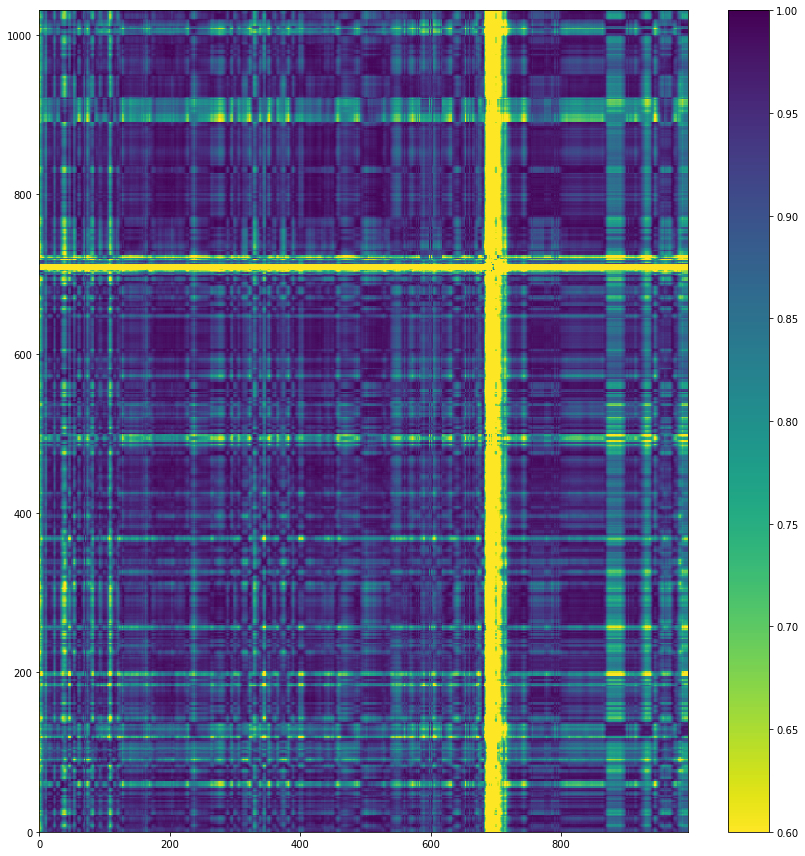

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
#plt.imshow(correlations, cmap='viridis_r', origin='upper')
plt.pcolor(correlations, cmap='viridis_r', vmin=0.6, vmax=1.0)
plt.colorbar()
plt.tight_layout()

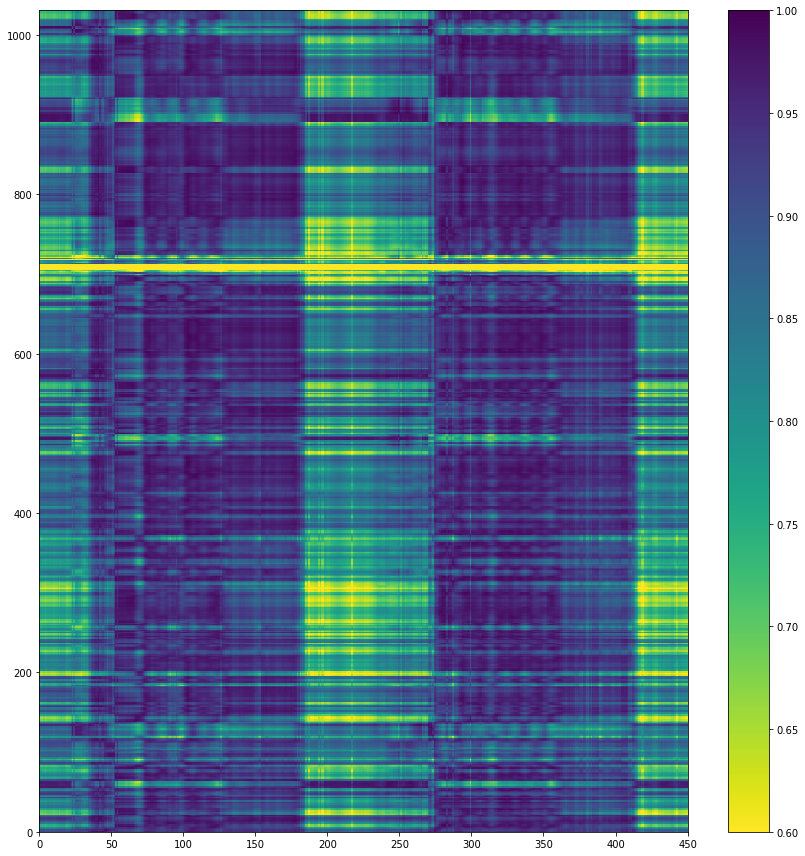

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
#plt.imshow(correlations, cmap='viridis_r', origin='upper')
plt.pcolor(correlations, cmap='viridis_r', vmin=0.6, vmax=1.0)
plt.colorbar()
plt.tight_layout()